In [543]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Parameter
from gpytorch.constraints import Positive, Interval


In [882]:
# create synthetic PV data created from an ODE model using cloud cover data and solar radiation data
from torchdiffeq import odeint
from alfi.utilities.torch import discretisation_length

class SyntheticPV:
    """ 
    Generate synthetic PV data using an ODE model.
    This will likely be inaccurate, but highlights the use of the LFM.

    It will be a 2D system with the following ODE (i.e. they are inverses of each other)
    dPV/dt = -a * C * PV + b *sin(c * t)
    dC/dt = a * C * PV - b * sin(c * t)

    """
    def __init__(self,
            pv_init : float = 0.2,
            cloud_init : float = 0.6,
            time_steps = 30,
            end_time = 25,
            num_discrete = 3,
            ):
        self.pv_init = pv_init
        self.cloud_init = cloud_init
        self.time_steps = time_steps
        self.end_time = end_time
        self.num_discrete = num_discrete

        times, X = self.generate_ts()

        self.data = []
        times_train = times[:int(len(times) * 0.9)]
        X_train = X[:int(len(times) * 0.9)]
        self.data.append((times_train[::num_discrete], X_train[::num_discrete, 1]))
        self.pv = X_train[:, 0]
        self.cloud = X_train[:, 1]
        self.times = times_train

        self.times_test = times[int(len(times) * 0.9):]
        self.data_test = []
        self.data_test.append((self.times_test[::num_discrete], X[int(len(times) * 0.9):][::num_discrete, 1]))
        self.pv_test = X[int(len(times) * 0.9):, 0]
        self.cloud_test = X[int(len(times) * 0.9):, 1]
    
    def generate_ts(self):
        a = np.random.uniform(0.001, 0.01)
        b = np.random.uniform(0.1, 0.5)
        c = np.random.uniform(0.1, 0.2)
      
        def dX_dt(t, X):
            return torch.stack([
               -a * X[1] + b * torch.sin(c * t * np.pi) *  X[0],
               a * X[0] - b * torch.sin(c * t * np.pi) * X[1],
               
            ])
        
        t = torch.linspace(0, self.end_time, discretisation_length(self.time_steps, self.num_discrete))
        X0 = torch.tensor([self.pv_init, self.cloud_init])
        X = odeint(dX_dt, X0, t, method='rk4', options=dict(step_size=5e-2))
        X += torch.randn_like(X) * 0.03

        self.true_params = {'a': a, 'b': b, 'c': c}
       
        return t, X
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)


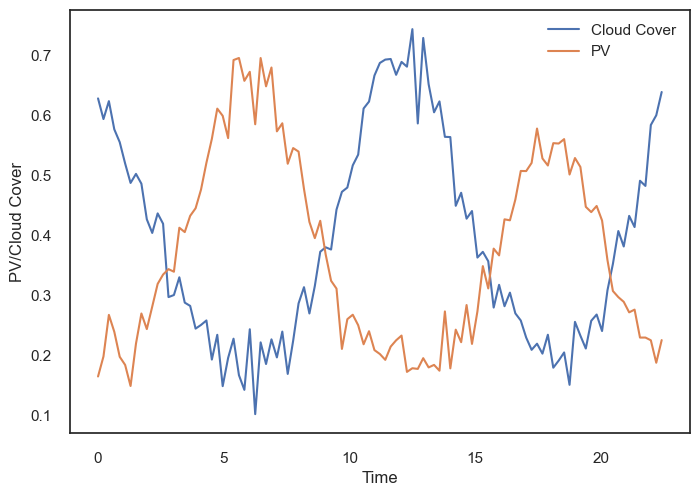

In [883]:
dataset = SyntheticPV(num_discrete=3)
plt.rcParams['font.family'] = 'Arial'
plt.plot(dataset.times, dataset.cloud, label='Cloud Cover')
plt.plot(dataset.times, dataset.pv, label='PV')
plt.legend()
plt.xlabel('Time')
plt.ylabel('PV/Cloud Cover');


In [884]:
num_latents = 1
num_outputs = 1
num_training = dataset.data[0][0].shape[0]
num_inducing = 30

In [885]:
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, mean, covar, likelihood):
        super().__init__(x_train, y_train, likelihood)
        self.mean_module = mean
        self.covar_module = covar
        self.likelihood = likelihood
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, x):
        self.eval()
        self.likelihood.eval()
        with torch.no_grad():
            return self.likelihood(self(x))
    
    def fit(self,n_iter, lr, verbose, print_freq=10):
        self.train()
        self.likelihood.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.train_inputs[0])
            loss = -mll(output, self.train_targets)
            loss.backward()
            optimizer.step()
            if verbose and i % print_freq == 0:
                print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))

In [886]:
import sys
import os
sys.path.append(os.path.abspath('../..'))
from kernels import Kernel
model_kernel = Kernel()
matern1 = model_kernel.get_matern()
matern_quasi = model_kernel.get_matern()
periodic = model_kernel.get_periodic()
covar = model_kernel.get_quasi_periodic(
    matern_base=matern1,
    matern_quasi=matern_quasi,
    periodic1=periodic,
)
mean = gpytorch.means.ConstantMean()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

gp_model = ExactGP(dataset.data[0][0], dataset.data[0][1], mean, covar, likelihood)

In [887]:
import torch
import numpy as np
from torch.nn import Parameter
from gpytorch.constraints import Interval
from torchdiffeq import odeint
from typing import Optional
# import softplus and inverse softplus from alfi.utilities.torch
from gpytorch.metrics import negative_log_predictive_density as nlpd

from torch import nn
def discretisation_length(N, d):
    """Returns the length of a linspace where there are N points with d intermediate (in-between) points."""
    return (N - 1) * (d + 1) + 1



class PVLFM(nn.Module):
    def __init__(self, dataset, num_outputs, gp_model, config, **kwargs):
        super().__init__()
        
        self.config = config
        self.num_outputs = num_outputs
        pv_init = dataset.pv_init
        self.dataset = dataset
        self.gp_model = gp_model
        
        self.raw_initial = torch.tensor(pv_init, dtype=torch.float64).repeat(self.num_outputs, 1)
        self.a_constr = Interval(0.001, 0.1)
        self.b_constr = Interval(0.1, 0.5)
        self.c_constr = Interval(0.1, 0.2)
        self.positive_constr = Positive()
        self.raw_a = Parameter(self.a_constr.inverse_transform(0.005 * torch.ones(torch.Size([num_outputs, 1]), dtype=torch.float64)))
        self.raw_b = Parameter(self.b_constr.inverse_transform(0.3 * torch.ones(torch.Size([num_outputs, 1]), dtype=torch.float64)))
        self.raw_c = Parameter(self.c_constr.inverse_transform(0.15 * torch.ones(torch.Size([num_outputs, 1]), dtype=torch.float64)))
        self.raw_noise = Parameter(self.positive_constr.inverse_transform(80 * torch.ones(torch.Size([num_outputs, 1]), dtype=torch.float64)))


    @property
    def a_rate(self):
        return self.a_constr.transform(self.raw_a)
    
    @a_rate.setter
    def a_rate(self, value):
        self.raw_a = self.a_constr.inverse_transform(value)
    
    @property
    def b_rate(self):
        return self.b_constr.transform(self.raw_b)
    
    @b_rate.setter
    def b_rate(self, value):
        self.raw_b = self.b_constr.inverse_transform(value)
    
    @property
    def c_rate(self):
        return self.c_constr.transform(self.raw_c)
    
    @c_rate.setter
    def c_rate(self, value):
        self.raw_c = self.c_constr.inverse_transform(value)
    
    @property
    def initial(self):
        return self.raw_initial
    
    @initial.setter
    def initial(self, value):
        self.raw_initial = value
    
    def initial_state(self):
        return self.raw_initial
    
    @property
    def noise_rate(self):
        return self.positive_constr.transform(self.raw_noise)
    
    @noise_rate.setter
    def noise_rate(self, value):
        self.raw_noise = self.positive_constr.inverse_transform(value)
    
    def pre_train_gp(self, n_iter =100, lr=0.1, verbose=False):
        self.gp_model.fit(n_iter=n_iter, lr=lr, verbose=verbose)
    
    def odefunc(self, t, h):

        f = self.f[:, :, self.t_index].unsqueeze(2)
        dh = -self.a_rate * f  + self.b_rate * torch.sin(self.c_rate * t * np.pi) * h
      
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t

        return dh
    
    def forward(self, t, step_size=0.33, num_discrete : Optional[list] = None):
        
        if num_discrete is None:
            t_f = t
            step_size =1
        else:
            t_f = torch.linspace(t.min(), t.max(), discretisation_length(t.shape[0], num_discrete))
        
        h0 = self.initial_state()
        h0 = h0.repeat(self.config.num_samples, 1, 1)
        self.t_index = 0
        self.last_t = -1
        
        self.gp_model.eval()
        qf = self.gp_model(t_f).rsample(torch.Size([self.config.num_samples]))
        
        self.f = qf.unsqueeze(1) if len(qf.shape) == 2 else qf
        h_samples = odeint(self.odefunc, h0, t_f, method='rk4', options=dict(step_size=step_size))
        
        h_mean = torch.mean(h_samples, dim=1).squeeze(-1).squeeze(-1)


        h_var = torch.var(h_samples, dim=1).transpose(0, 1).squeeze(-1).squeeze(-1) + 1e-6
        h_covar = torch.diag_embed(h_var)
        # add learnable noise with shape 
        h_covar *= self.noise_rate
        h_dist = gpytorch.distributions.MultivariateNormal(h_mean, h_covar)
        return h_dist

    def fit(self, n_iter=100, lr=0.2, step_size=0.33, warm_start=True):
        
        if warm_start:
            self.gp_model.fit(n_iter=n_iter, lr=lr, verbose=True)
        
        
        y_target = torch.tensor(self.dataset.pv, dtype=torch.float64)       
        lfm_params = [p for p in self.parameters() if p not in self.gp_model.parameters()]
        optimizer = torch.optim.Adam(lfm_params, lr=lr)
        
        for i in range(n_iter):
            optimizer.zero_grad()
            output_lfm = self(self.dataset.times, step_size=step_size)
            
            loss = nlpd(output_lfm, y_target)
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f'Iteration {i}, loss {loss.item()}')
    
    def predict_pv(self, 
                   t, 
                   initial_state_pred, 
                   initial_var_pred,
                   step_size=0.33, 
                   num_discrete : Optional[int] = None,
                   fit_gp=False):
        # get gp samples at t
        if fit_gp:
            self.gp_model = ExactGP(
                self.dataset.data_test[0][0],
                self.dataset.data_test[0][1],
                self.gp_model.mean_module,
                self.gp_model.covar_module,
                self.gp_model.likelihood
            )
            self.gp_model.fit(n_iter=100, lr=0.1, verbose=False)
            
        self.gp_model.eval()
        qf = self.gp_model(t).rsample(torch.Size([self.config.num_samples]))
        self.f = qf.unsqueeze(1) if len(qf.shape) == 2 else qf
  
        h0 = torch.distributions.Normal(initial_state_pred, initial_var_pred).sample(torch.Size([self.config.num_samples])).unsqueeze(-1).unsqueeze(-1)
        self.t_index = 0
        self.last_t = -1

        if num_discrete is None:
            t_f = t
            step_size = 1
        else:
            t_f = torch.linspace(t.min(), t.max(), discretisation_length(t.shape[0], num_discrete))
        
        h_samples = odeint(self.odefunc, h0, t_f, method='rk4', options=dict(step_size=step_size))
        h_mean = torch.mean(h_samples, dim=1).squeeze(-1).squeeze(-1)

        h_covar = torch.var(h_samples, dim=1).transpose(0, 1).squeeze(-1).squeeze(-1) + 1e-6
        h_covar *= self.noise_rate
        h_dist = gpytorch.distributions.MultivariateNormal(h_mean, torch.diag_embed(h_covar))

        with torch.no_grad():
            self.gp_model.eval()
            self.gp_model.likelihood.eval()
            latent_posterior = self.gp_model.likelihood(self.gp_model(t))
        
        return h_dist, latent_posterior


        


In [888]:
from alfi.configuration import VariationalConfiguration
config = VariationalConfiguration(num_samples=70)
model = PVLFM(dataset=dataset,
        num_outputs=1,
        gp_model=gp_model,
        config=config)


In [889]:
model.fit(n_iter=100)

Iter 1/100 - Loss: 1.209
Iter 11/100 - Loss: 0.151
Iter 21/100 - Loss: -0.711
Iter 31/100 - Loss: -1.215
Iter 41/100 - Loss: -1.302
Iter 51/100 - Loss: -1.285
Iter 61/100 - Loss: -1.308
Iter 71/100 - Loss: -1.318
Iter 81/100 - Loss: -1.318
Iter 91/100 - Loss: -1.262
Iteration 0, loss 7.075607073479629
Iteration 10, loss -0.9950403502634368
Iteration 20, loss -1.0877043277569558
Iteration 30, loss -1.0212241983626058
Iteration 40, loss -1.136043204318584
Iteration 50, loss -1.284282956306024
Iteration 60, loss -1.3610678616044802
Iteration 70, loss -1.3807506456757064
Iteration 80, loss -1.3795119120625887
Iteration 90, loss -1.4297579612973312


torch.Size([70, 1, 1])


(0.0218965008854866, 1.0855732440948487)

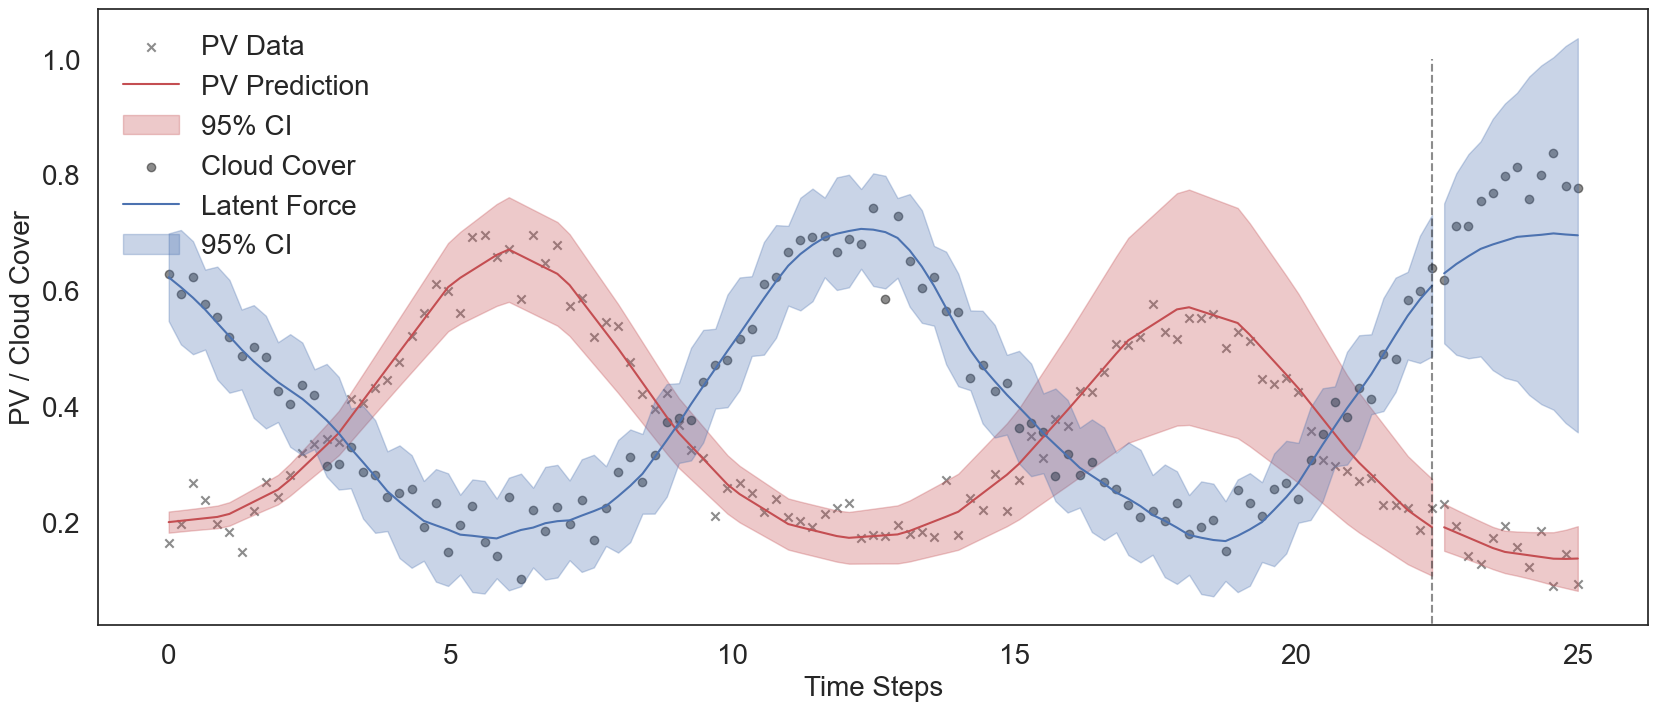

In [914]:
y_pred_pv = model(dataset.times)
pv_mean1 = y_pred_pv.mean.detach().squeeze(0).numpy()
pv_var1 = y_pred_pv.variance.detach().squeeze(0).numpy()

y_pred_gp = gp_model.predict(dataset.times)
mean_gp = y_pred_gp.mean.detach().squeeze(0).numpy()
var_gp = y_pred_gp.variance.detach().squeeze(0).numpy()

pred_times = dataset.times_test
pv_dist, cloud_dist = model.predict_pv(pred_times, initial_state_pred=pv_mean1[-1], initial_var_pred=pv_var1[-1])

pv_mean = pv_dist.mean.detach().squeeze(0).numpy()
pv_var = pv_dist.variance.detach().squeeze(0).numpy()

cloud_mean = cloud_dist.mean.detach().squeeze(0).numpy()
cloud_var = cloud_dist.variance.detach().squeeze(0).numpy()

fig, ax = plt.subplots(figsize=(20, 8))

ax.scatter(dataset.times, dataset.pv, label='PV Data', color='k', marker='x', alpha=0.5)
ax.plot(dataset.times, pv_mean1, label='PV Prediction', color='r')
ax.fill_between(dataset.times,
        pv_mean1 - 1.96 * np.sqrt(pv_var1),
        pv_mean1 + 1.96 * np.sqrt(pv_var1),
        alpha=0.3, label='95% CI', color='r')


ax.scatter(dataset.times, dataset.cloud, label='Cloud Cover', color='k', marker='o', alpha=0.5)
ax.plot(dataset.times, mean_gp, label='Latent Force', color='b')
ax.fill_between(dataset.times,
        mean_gp - 1.96 * np.sqrt(var_gp),
        mean_gp + 1.96 * np.sqrt(var_gp),
        alpha=0.3, label='95% CI', color='b')

y_min1 = min(min(pv_mean1 - 1.96 * np.sqrt(pv_var1)), min(mean_gp - 1.96 * np.sqrt(var_gp)))
y_max1 = max(max(pv_mean1 + 1.96 * np.sqrt(pv_var1)), max(mean_gp + 1.96 * np.sqrt(var_gp)))


ax.scatter(dataset.times_test, dataset.pv_test, color='k', marker='x', alpha=0.5)
ax.plot(dataset.times_test, pv_mean, color='r')
ax.fill_between(dataset.times_test,
        pv_mean - 1.96 * np.sqrt(pv_var),
        pv_mean + 1.96 * np.sqrt(pv_var),
        alpha=0.3, color='r')

ax.scatter(dataset.times_test, dataset.cloud_test, color='k', marker='o', alpha=0.5)
ax.plot(dataset.times_test, cloud_mean, color='b')
ax.fill_between(dataset.times_test,
        cloud_mean - 1.96 * np.sqrt(cloud_var),
        cloud_mean + 1.96 * np.sqrt(cloud_var),
        alpha=0.3, color='b')

ax.vlines(dataset.times[-1], -1, 1, color='k', linestyle='--', alpha=0.5)

ax.legend(loc='upper left', fontsize=20)
ax.set_xlabel('Time Steps', fontsize=20)
ax.set_ylabel('PV / Cloud Cover', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

y_min_2 = min(min(pv_mean - 1.96 * np.sqrt(pv_var)), min(cloud_mean - 1.96 * np.sqrt(cloud_var)))
y_max_2 = max(max(pv_mean + 1.96 * np.sqrt(pv_var)), max(cloud_mean + 1.96 * np.sqrt(cloud_var)))

y_min, y_max = min(y_min1, y_min_2), max(y_max1, y_max_2)
ax.set_ylim(y_min -0.05, y_max + 0.05)






